# Тестовое задание для позиции data scientist в SCORR
## Стенина Мария Михайловна

Текст задания по ссылке https://docs.google.com/document/d/1Ame5oV-CMoIP-ncC2Qc_sXSwQST0CXcV7PwKqQBy6VE

Пункты 1 и 2.

In [1]:
%pylab inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Чтение данных 

Все неформатные строки из данных были удалены.

In [29]:
def ReadVertices (folder):
    filenames = os.listdir(folder)
    columns = ['id', 'generation', 'birthDates', 'cities']
    vertices = pd.DataFrame(columns=columns)
    for f in filenames:
        new_vertices = pd.read_csv(folder + '/' + f, sep=';', header=None, dtype={0:int, 1:int, 2:str, 3:str})
        new_vertices.columns = columns
        vertices = vertices.append(new_vertices, ignore_index=True)
    return vertices

In [49]:
folder = 'vertices'
vertices = ReadVertices(folder)
vertices.to_csv('data.csv')

In [50]:
vertices.head(10)

,id,generation,birthDates,cities
0,0,2,0000-03-05,praha
1,8192,2,0000-11-12,северодвинск
2,16384,2,0000-03-30,киев
3,24576,2,1995-09-24,фастов
4,32768,2,0000-10-12,NaN
5,40960,2,1999-01-23,ангарск
6,49152,2,NaN,ужгород
7,57344,2,NaN,NaN
8,65536,2,0000-09-19,ставрополь
9,73728,2,NaN,томск


In [51]:
print vertices.shape[0], 'vertices'

6762283 vertices


In [54]:
counts = vertices.generation.value_counts()
print counts

2    6728914
1      32851
0        518
dtype: int64


In [56]:
counts[0]

518

В поколении 0 - 518 вершин, в поколении 1 - 32851 вершина, в поколении 2 - 6728914 вершин.

# Среднее количество друзей 

In [31]:
files_vertices = os.listdir('vertices')
files_friends = os.listdir('adjacency_list')
files_vertices == files_friends

True

In [46]:
files = files_vertices

friends_gen_0 = []
friends_gen_1 = []

for filename in files:
    vertices = pd.read_csv('vertices/' + filename, sep=';', header=None, dtype={0:int, 1:int, 2:str, 3:str})
    for string in open('adjacency_list/' + filename):
        string = string.strip()
        [source, destinations] = string.split('Set')
        source = int(source[1:-1])
        if vertices.values[vertices[0].values == source, 1] == 0:
            friends_gen_0.append(len(destinations[1:-2].split(',')))
        elif vertices.values[vertices[0].values == source, 1] == 1:
            friends_gen_1.append(len(destinations[1:-2].split(',')))
        else:
            print 'Bad data'

In [53]:
print len(friends_gen_0), 'vertices in generation 0 have friends'
print len(friends_gen_1), 'vertices in generation 1 have friends'

500 vertices in generation 0 have friends
32676 vertices in generation 1 have friends


Так как количества вершин отличаются от вычисленных ранее, то в папке adjacency_list есть информация о друзьях не всех представителей поколений 0 и 1. Предполагаю, что при отсутствии информации о друзьях, друзей у данного человека в сети нет, поэтому дополняю недостающие элементы нулями.

In [57]:
friends_gen_0 += [0] * (counts[0] - len(friends_gen_0))
friends_gen_1 += [0] * (counts[1] - len(friends_gen_1))

In [58]:
print 'Mean number of friends in generation 0 is %.2f' % np.mean(np.array(friends_gen_0))
print 'Mean number of friends in generation 1 is %.2f' % np.mean(np.array(friends_gen_1))

Mean number of friends in generation 0 is 63.48
Mean number of friends in generation 1 is 455.10


# Корреляция возраста человека с возрастом его друзей 

Для быстрого сбора статистики по друзьям заводим словарь, у которого ключами будут id, а значениями - строки с датами рождения. Также для следующей части задания сразу сделаем словарь, у которого значениями будут строки с городами.

In [3]:
files = os.listdir('vertices')
birth_dates = {}
cities = {}
for filename in files:
    for string in open('vertices/' + filename):
        string = string.strip()
        values = string.split(';')
        user = int(values[0])
        birth_dates[user] = values[2]
        cities[user] = values[3]

В выборку для анализа войдут только вершины из поколений 0 и 1, потому что только для них известны списки друзей. В анализ не будут входить те люди, у которых не указан год рождения или у которых нет друзей с корректно указанной датой рождения. Будет считаться, что у человека указан год рождения в следующих случаях:
- Указана только одна дата рождения полностью (день, месяц, год).
- Указано несколько дат, во всех совпадают месяц и день, год либо один и тот же, либо не указан. Тогда годом рождения считается год из даты, где он указан.

Если человеку более 70 лет или менее 5, то дата рождения считается не указанной. Очень пожилые люди и маленькие дети обычно не пользуются социальными сетями, скорее всего указанная дата не соответствует действительности. Включать таких пользователей в выборку для обучения алгоритма - только зашумлять данные.

Для каждого человека из поколений 0 и 1 с указанным годом рождения вычисляются следующие признаки:
- количество друзей всего,
- количество друзей, у которых указан год рождения,
- средний год рождения друзей,
- медианный год рождения друзей,
- максимальный год рождения друзей (возраст самого молодого друга),
- минимальный год рождения друзей (возраст самого старшего друга).

Последние четыре признака вычисляются по тем друзьям, у которых год рождения указан.

In [31]:
import datetime

def GetYearOfBirth (birth_dates):
    """
    return year of birth if it is correct and -1 otherwise
    """
    if len(birth_dates) == 0:
        return -1
    
    dates = birth_dates.split('|')
    current_year = datetime.date.today().year
    if len(dates) == 1:
        [year, month, day] = dates[0].split('-')
        if year != '0000' and 5 <= current_year - int(year) <= 70:
            return int(year)
        else:
            return -1
            
    else:
        dates_parced = np.array([date.split('-') for date in dates])
        if np.all(dates_parced[:, -1] == dates_parced[0, -1]) and np.all(dates_parced[:, 1] == dates_parced[0, 1]):
            for year in dates_parced[:, 0]:
                if year != '0000':
                    break
            if np.all(np.logical_or(dates_parced[:, 0] == '0000', dates_parced[:, 0] == year)):
                if 5 <= current_year - int(year) <= 70:
                    return int(year)
                else:
                    return -1
            else:
                return -1
        else:
            return -1

In [32]:
years_of_birth = []
features_birth = []

for filename in files:
    for s_friends in open('adjacency_list/' + filename):
        s_friends = s_friends.strip()
        [source, destinations] = s_friends.split('Set')
        source = int(source[1:-1])
        try:
            year = GetYearOfBirth(birth_dates[source]) 
        except KeyError:
            continue
        if year == -1:
            continue
        
        friends = map(int, destinations[1:-2].split(','))
        friends_number = len(friends)
        if friends_number == 0:
            continue
                
        friends_with_year_of_birth = 0
        friends_years = []
        for friend in friends:
            try:
                friend_year = GetYearOfBirth(birth_dates[friend])
            except KeyError:
                continue
            if friend_year != -1:
                friends_with_year_of_birth += 1
                friends_years.append(friend_year)
        if friends_with_year_of_birth > 0:
            years_of_birth.append(year)                            
            features_birth.append([friends_number, friends_with_year_of_birth, np.mean(friends_years), 
                                   np.median(friends_years), np.max(friends_years), np.min(friends_years)])

In [33]:
features_birth = np.array(features_birth)
print features_birth[:5, :]

[[   23.            10.          1991.2         1991.          1993.          1989.        ]
 [   70.            34.          1994.94117647  1996.          2000.          1979.        ]
 [  434.           184.          1989.76630435  1990.          2000.          1966.        ]
 [   71.            41.          1988.19512195  1990.          2000.          1951.        ]
 [  116.            43.          1995.06976744  1997.          1999.          1975.        ]]


In [34]:
birth_data_frame = pd.DataFrame(data=features_birth, columns=['friends', 'friends_with_year_of_birth', 'mean', 
                                                              'med', 'max', 'min'])
birth_data_frame['target'] = years_of_birth
birth_data_frame.to_csv('BirthDataFrame.csv', index=False)

## Корреляция возраста человека со статистиками возраста его друзей 

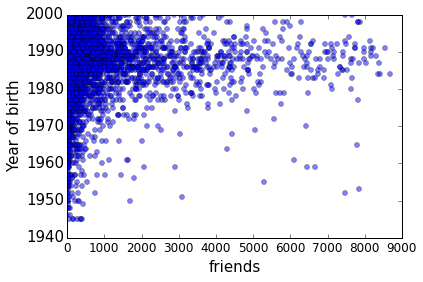

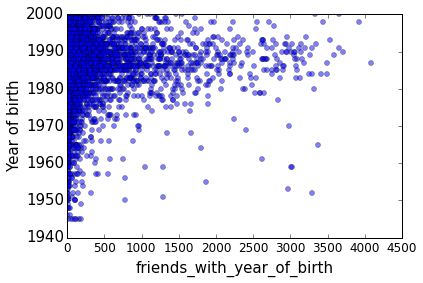

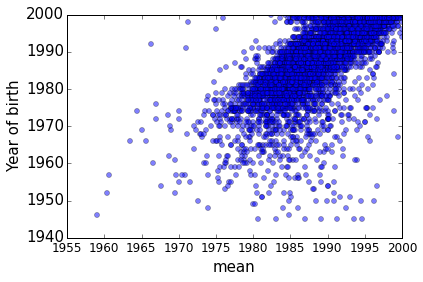

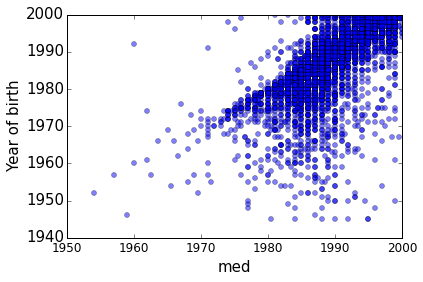

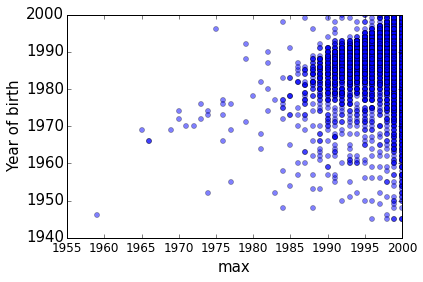

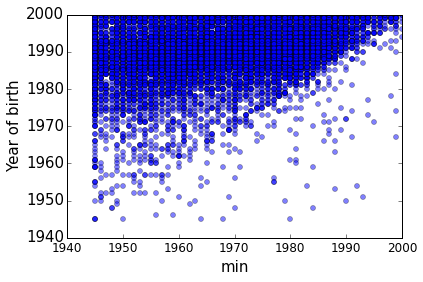

In [35]:
for feature in list(birth_data_frame.columns)[:-1]:
    plt.figure()
    plt.plot(birth_data_frame[feature], birth_data_frame.target, 'bo', ms=5, alpha=0.5)
    plt.xlabel(feature, fontsize=15)
    plt.ylabel('Year of birth', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)

## Анализ построенных графиков

1) Наибольшее количество друзей у людей, чей год рождения попадает в диапазон от 1980 до 1995 года. Им сейчас от 20 до 35 лет. (Первый и второй построенные графики). Количество друзей, у которых указан год рождения, примерно вдвое меньше, чем общее количество друзей у человека.

2) Из предпоследнего и последнего графиков видно, что в подавляющем большинстве случаев возраст самого старшего друга больше, чем возраст человека, а возраст самого молодого друга меньше, чем возраст человека. Следовательно, год рождения самого молодого друга можно использовать как верхнюю оценку года рождения человека, а год рождения самого старшего друга - как нижнюю оценку.

3) По третьему графику можно заключить, что средний возраст друзей, как правило, отличается от возраста человека не больше, чем на 10 лет.

4) Четвертый график. Медианный возраст друзей не больше возраста человека, если год его рождения не позднее 1985.

Добавим к признакам 0.25 и 0.75-квантили распределения годов рождения друзей, а также стандартное отклонение.

In [37]:
features_birth = []

for filename in files:
    for s_friends in open('adjacency_list/' + filename):
        s_friends = s_friends.strip()
        [source, destinations] = s_friends.split('Set')
        source = int(source[1:-1])
        try:
            year = GetYearOfBirth(birth_dates[source]) 
        except KeyError:
            continue
        if year == -1:
            continue
        
        friends = map(int, destinations[1:-2].split(','))
        friends_number = len(friends)
        if friends_number == 0:
            continue
                
        friends_with_year_of_birth = 0
        friends_years = []
        for friend in friends:
            try:
                friend_year = GetYearOfBirth(birth_dates[friend])
            except KeyError:
                continue
            if friend_year != -1:
                friends_with_year_of_birth += 1
                friends_years.append(friend_year)
        if friends_with_year_of_birth > 0:                           
            features_birth.append([np.percentile(friends_years, 25), np.percentile(friends_years, 75), np.std(friends_years)])

In [38]:
features_birth = np.array(features_birth)
print features_birth[:5, :]

[[  1.99100000e+03   1.99175000e+03   1.16619038e+00]
 [  1.99300000e+03   1.99800000e+03   4.78318855e+00]
 [  1.98800000e+03   1.99100000e+03   3.89045033e+00]
 [  1.98900000e+03   1.99100000e+03   7.98235711e+00]
 [  1.99500000e+03   1.99800000e+03   4.58204458e+00]]


In [39]:
birth_data_frame['0_25_quantile'] = features_birth[:, 0]
birth_data_frame['0_75_quantile'] = features_birth[:, 1]
birth_data_frame['std'] = features_birth[:, 2]
birth_data_frame.to_csv('BirthDataFrame.csv', index=False)

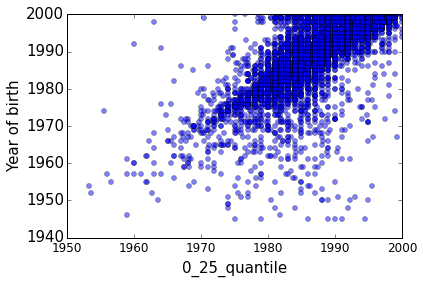

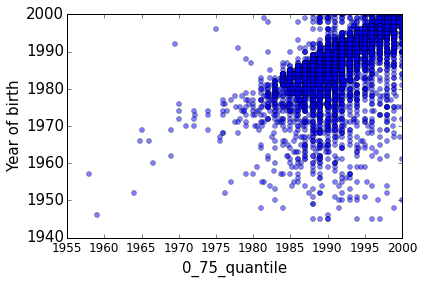

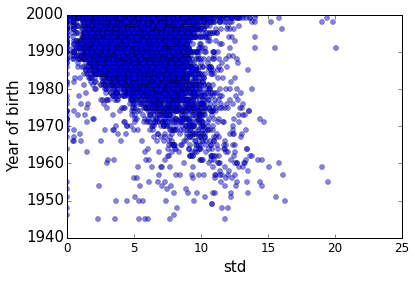

In [40]:
for feature in list(birth_data_frame.columns)[-3:]:
    plt.figure()
    plt.plot(birth_data_frame[feature], birth_data_frame.target, 'bo', ms=5, alpha=0.5)
    plt.xlabel(feature, fontsize=15)
    plt.ylabel('Year of birth', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)

Зависимость возраста человека от квантилей распределения годов рождения его друзей похожа на зависимость от среднего и медианного годов рождения. И чем больше стандартное отклонение годов рождения друзей, тем больше может быть возраст человека. Скорее всего, это связано с тем, что люди более старшего поколения добавляют в друзья не только своих ровесников, но и своих детей и их друзей-ровесников.

## Предсказание года рождения человека 

Поскольку при анализе графиков зависимости года рождения пользователя от различных статистик возрастов его друзей были видны логические закономерности, то имеет смысл попробовать предсказывать год рождения при помощи решающего дерева. Но поскольку одно дерево - очень неустойвая модель, то использовать я буду RandomForestRegressor. Линейная регрессия, скорее всего, для этой задачи не подойдет, потому хорошо просматривающихся линейных зависимостей на графиках нет.

Точность предсказания я буду оценивать с помощью метрики mean_absolute_error, так как ее значение можно интерпретировать как среднюю разницу предсказанного и реального возраста, в отличие от других метрик качества регрессионных задач.

Качество предсказаний будет оцениваться на отложенной выборке, параметры алгоритма настраиваться с помощью кросс-валидации.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split, cross_val_score

def scorer (estimator, X, y):
    return (mean_absolute_error(y, np.round(estimator.predict(X))))

In [3]:
birth_data_frame = pd.read_csv('BirthDataFrame.csv')
target = birth_data_frame.target
birth_data_frame = birth_data_frame.drop(['target'], 1)

In [4]:
list(birth_data_frame.columns)

['friends',
 'friends_with_year_of_birth',
 'mean',
 'med',
 'max',
 'min',
 '0_25_quantile',
 '0_75_quantile',
 'std']

In [46]:
print birth_data_frame.shape[0], 'users'

14279 users


In [6]:
X_train, X_test, y_train, y_test = train_test_split(birth_data_frame.values, target, test_size=0.3)

### Настройка параметров алгоритма 

Алгоритм в качестве предсказания дает вещественное число, поэтому полученные предсказания округляются до ближайшего целого числа, чтобы полученное число можно было считать годом. Округление происходит внутри функции scorer.

In [8]:
mean_error = []
std_error = []
for n_trees in np.logspace(1, 4, num=30, dtype=int):
    estimator = RandomForestRegressor(n_estimators=n_trees, max_depth=20, n_jobs=-1, random_state=345)
    cv_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring=scorer)
    mean_error.append(np.mean(cv_score))
    std_error.append(np.std(cv_score))
    print '%d trees: mean absolute error is %.2f +/- %.2f' % (n_trees, mean_error[-1], std_error[-1])

10 trees: mean absolute error is 2.32 +/- 0.06
12 trees: mean absolute error is 2.29 +/- 0.06
16 trees: mean absolute error is 2.27 +/- 0.07
20 trees: mean absolute error is 2.24 +/- 0.07
25 trees: mean absolute error is 2.24 +/- 0.07
32 trees: mean absolute error is 2.23 +/- 0.06
41 trees: mean absolute error is 2.23 +/- 0.06
52 trees: mean absolute error is 2.22 +/- 0.06
67 trees: mean absolute error is 2.21 +/- 0.06
85 trees: mean absolute error is 2.21 +/- 0.06
108 trees: mean absolute error is 2.20 +/- 0.06
137 trees: mean absolute error is 2.20 +/- 0.06
174 trees: mean absolute error is 2.20 +/- 0.05
221 trees: mean absolute error is 2.20 +/- 0.05
280 trees: mean absolute error is 2.19 +/- 0.05
356 trees: mean absolute error is 2.19 +/- 0.06
452 trees: mean absolute error is 2.19 +/- 0.06
573 trees: mean absolute error is 2.19 +/- 0.06
727 trees: mean absolute error is 2.19 +/- 0.05
923 trees: mean absolute error is 2.19 +/- 0.05
1172 trees: mean absolute error is 2.18 +/- 0.05
1

(array([ 2.1 ,  2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,  2.45]),
 <a list of 8 Text yticklabel objects>)

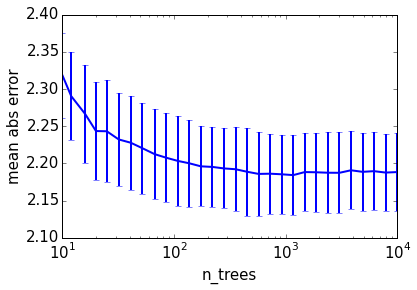

In [9]:
plt.errorbar(np.logspace(1, 4, num=30, dtype=int), mean_error, yerr=std_error, linewidth=2)
plt.xscale('log')
plt.xlabel('n_trees', fontsize=15)
plt.ylabel('mean abs error', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

### Предварительные наблюдения

Год рождения предсказывается в среднем с ошибкой чуть более двух лет. При использовании более 1000 деревьев качество на кросс-валидации перестает улучшаться, поэтому настройка глубины деревьев будет проводиться для леса из 1000 деревьев, чтобы не переусложнять модель.

### Настройка глубины деревьев

In [10]:
mean_error = []
std_error = []
for depth in np.linspace(1, 25, num=25, dtype=int):
    estimator = RandomForestRegressor(n_estimators=1000, max_depth=depth, n_jobs=-1, random_state=345)
    cv_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring=scorer)
    mean_error.append(np.mean(cv_score))
    std_error.append(np.std(cv_score))
    print 'max_depth = %d: mean absolute error is %.2f +/- %.2f' % (depth, mean_error[-1], std_error[-1])

max_depth = 1: mean absolute error is 3.66 +/- 0.06
max_depth = 2: mean absolute error is 2.68 +/- 0.05
max_depth = 3: mean absolute error is 2.29 +/- 0.06
max_depth = 4: mean absolute error is 2.16 +/- 0.05
max_depth = 5: mean absolute error is 2.14 +/- 0.05
max_depth = 6: mean absolute error is 2.14 +/- 0.05
max_depth = 7: mean absolute error is 2.14 +/- 0.05
max_depth = 8: mean absolute error is 2.13 +/- 0.05
max_depth = 9: mean absolute error is 2.11 +/- 0.05
max_depth = 10: mean absolute error is 2.12 +/- 0.05
max_depth = 11: mean absolute error is 2.13 +/- 0.05
max_depth = 12: mean absolute error is 2.15 +/- 0.05
max_depth = 13: mean absolute error is 2.15 +/- 0.05
max_depth = 14: mean absolute error is 2.16 +/- 0.06
max_depth = 15: mean absolute error is 2.17 +/- 0.05
max_depth = 16: mean absolute error is 2.18 +/- 0.06
max_depth = 17: mean absolute error is 2.18 +/- 0.05
max_depth = 18: mean absolute error is 2.18 +/- 0.05
max_depth = 19: mean absolute error is 2.18 +/- 0.05
ma

(array([ 2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8]),
 <a list of 10 Text yticklabel objects>)

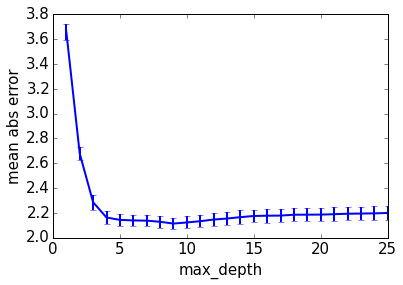

In [11]:
plt.errorbar(np.linspace(1, 25, num=25, dtype=int), mean_error, yerr=std_error, linewidth=2)
plt.xlabel('max_depth', fontsize=15)
plt.ylabel('mean abs error', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

Минимум ошибки соответствует деревьям глубины 9. Возможно, при этой глубине оптимальное количество деревьев отличается от 1000. Поэтому попробуем еще раз подобрать количество деревьев.

In [12]:
mean_error = []
std_error = []
for n_trees in np.logspace(1, 4, num=30, dtype=int):
    estimator = RandomForestRegressor(n_estimators=n_trees, max_depth=9, n_jobs=-1, random_state=345)
    cv_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring=scorer)
    mean_error.append(np.mean(cv_score))
    std_error.append(np.std(cv_score))
    print '%d trees: mean absolute error is %.2f +/- %.2f' % (n_trees, mean_error[-1], std_error[-1])

10 trees: mean absolute error is 2.17 +/- 0.05
12 trees: mean absolute error is 2.16 +/- 0.05
16 trees: mean absolute error is 2.15 +/- 0.05
20 trees: mean absolute error is 2.14 +/- 0.05
25 trees: mean absolute error is 2.14 +/- 0.05
32 trees: mean absolute error is 2.13 +/- 0.05
41 trees: mean absolute error is 2.12 +/- 0.05
52 trees: mean absolute error is 2.12 +/- 0.05
67 trees: mean absolute error is 2.12 +/- 0.05
85 trees: mean absolute error is 2.12 +/- 0.06
108 trees: mean absolute error is 2.12 +/- 0.05
137 trees: mean absolute error is 2.12 +/- 0.05
174 trees: mean absolute error is 2.12 +/- 0.05
221 trees: mean absolute error is 2.12 +/- 0.05
280 trees: mean absolute error is 2.12 +/- 0.05
356 trees: mean absolute error is 2.12 +/- 0.04
452 trees: mean absolute error is 2.12 +/- 0.05
573 trees: mean absolute error is 2.12 +/- 0.05
727 trees: mean absolute error is 2.11 +/- 0.05
923 trees: mean absolute error is 2.11 +/- 0.05
1172 trees: mean absolute error is 2.11 +/- 0.05
1

(array([ 2.06,  2.08,  2.1 ,  2.12,  2.14,  2.16,  2.18,  2.2 ,  2.22]),
 <a list of 9 Text yticklabel objects>)

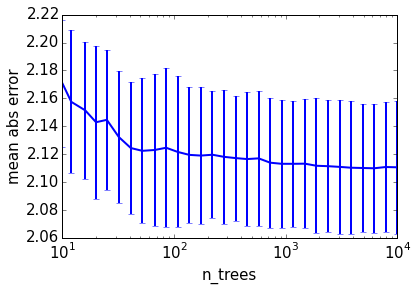

In [13]:
plt.errorbar(np.logspace(1, 4, num=30, dtype=int), mean_error, yerr=std_error, linewidth=2)
plt.xscale('log')
plt.xlabel('n_trees', fontsize=15)
plt.ylabel('mean abs error', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

На 1000 деревьев, пожалуй, стоит остановиться.

### Тестирование алгоритма на отложенной выборке

In [15]:
n_trees = 1000
depth = 9
estimator = RandomForestRegressor(n_estimators=n_trees, max_depth=depth, n_jobs=-1, random_state=345)
estimator.fit(X_train, y_train)
print 'mean absolute error on test is %.2f' % scorer(estimator, X_test, y_test)

mean absolute error on test is 2.05


Ошибка несколько меньше, чем была на кросс-валидации. Скорее всего, переобучения нет.

## Зависимость точности от количества друзей / статистик возраста друзей

Графики построены для всех признаков, по которым была построена регрессионная модель. Для каждого признака построены два графика. На правом графике каждая точка соответствует одному пользователю, попавшему в тестовую выборку. По оси абсцисс на этих графиках отложены значения признаков, по оси ординат - абсолютная ошибка предсказания года рождения для конкретного человека.

На левом графике представлена агрегированная информация. Диапазон значений каждого признака был разбит на отрезки равной длины, внутри каждого отрезка была вычеслена средняя ошибка прогнозирования. На графиках по оси ординат отложена средняя ошибка внутри отрезка, по оси абсцисс - координаты середин отрезков, на которые были разбиты интервалы значений признаков.

In [22]:
def ResearchError (y_true, y_pred, feature, bins):
    cuts = np.linspace(feature.min(), feature.max(), num=bins+1)
    mean_abs_error = np.zeros(bins)
    for i in xrange(bins):
        bin_idx = np.logical_and(feature >= cuts[i], feature < cuts[i+1])
        mean_abs_error[i] = mean_absolute_error(y_true[bin_idx], np.round(y_pred[bin_idx]))
    return mean_abs_error, (cuts[:-1] + cuts[1:]) / 2

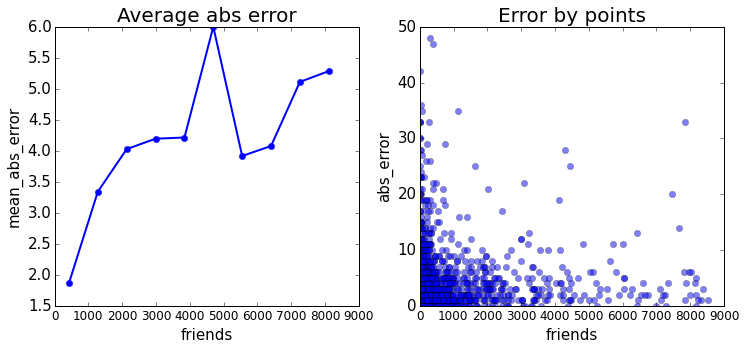

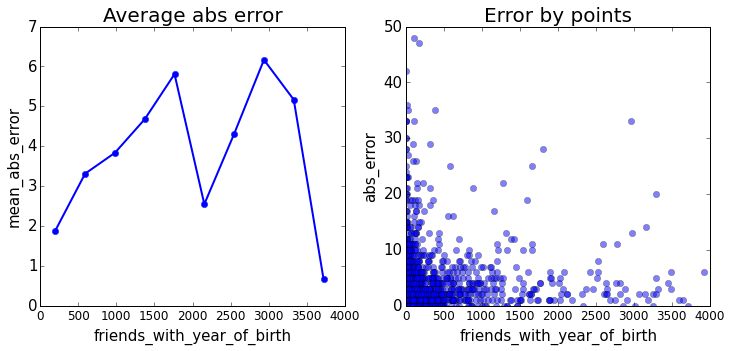

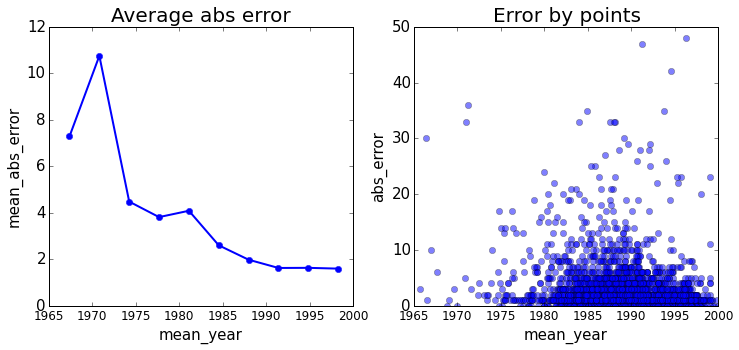

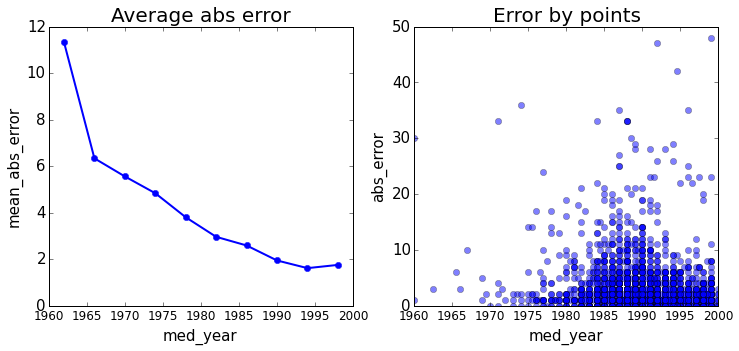

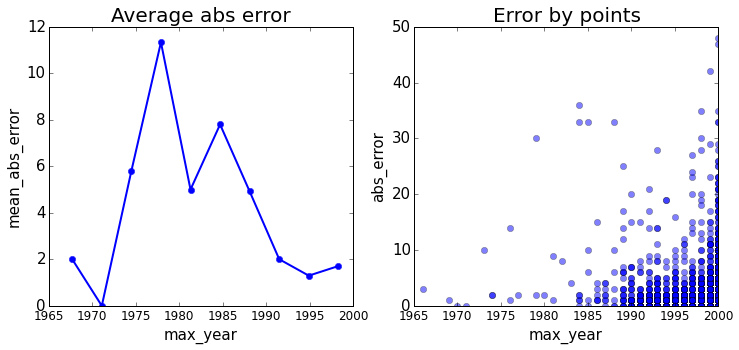

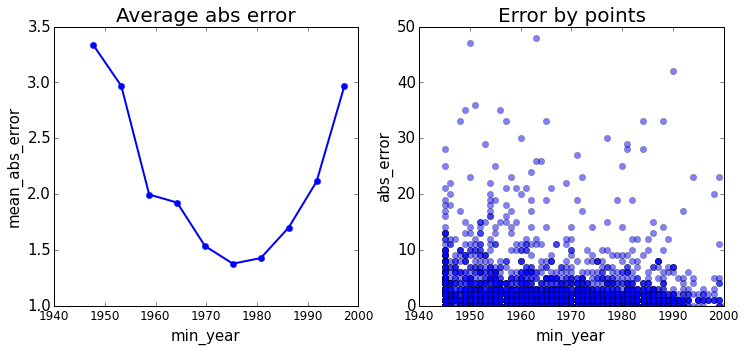

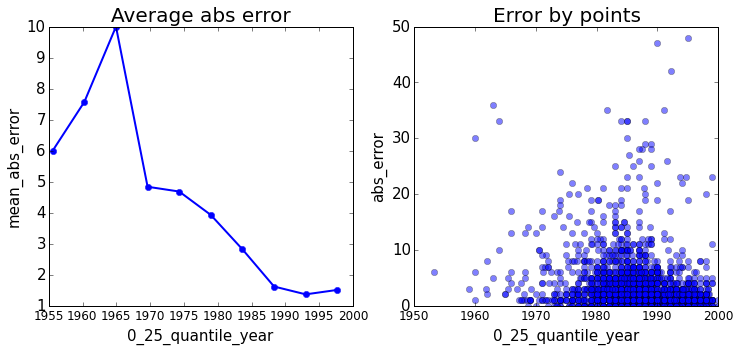

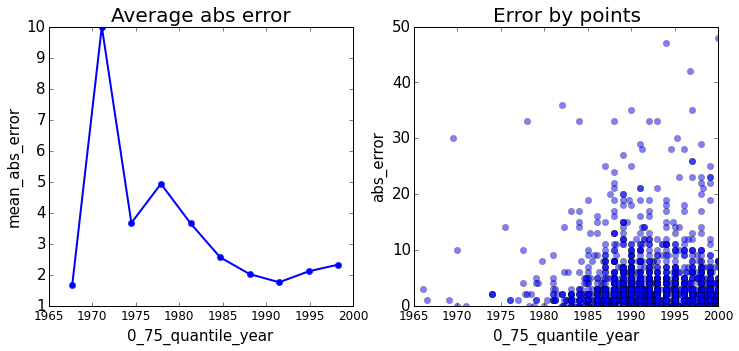

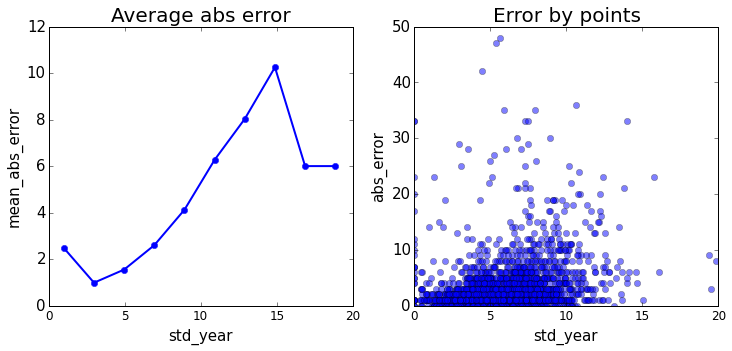

In [48]:
y_pred = estimator.predict(X_test)
for i in xrange(X_test.shape[1]):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    error, feature_values = ResearchError(y_test, y_pred, X_test[:, i], bins=10)
    plt.plot(feature_values, error, 'b-', linewidth=2)
    plt.plot(feature_values, error, 'b.', ms=12)
    if i < 2:
        plt.xlabel(list(birth_data_frame.columns)[i], fontsize=15)
    else:
        plt.xlabel(list(birth_data_frame.columns)[i] + '_year', fontsize=15)
    plt.ylabel('mean_abs_error', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)
    plt.title('Average abs error', fontsize=20)
    
    plt.subplot(122)
    plt.plot(X_test[:, i], np.abs(y_test - np.round(y_pred)), 'bo', alpha=0.5)
    if i < 2:
        plt.xlabel(list(birth_data_frame.columns)[i], fontsize=15)
    else:
        plt.xlabel(list(birth_data_frame.columns)[i] + '_year', fontsize=15)
    plt.ylabel('abs_error', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)
    plt.title('Error by points', fontsize=20)

Поскольку распределение пользователей по значениям признаков не равномерно, точки агрегированных графиков, попавшие в интервалы с небольшим количеством пользователей, не вызывают доверия. Чтобы скомпенсировать неравномерность распределения объектов, будем разбивать диапазоны значений признаков по квантилям.

In [42]:
def ResearchErrorQuantiles (y_true, y_pred, feature, bins):
    cuts = np.percentile(feature, np.linspace(0, 100, num=bins+1))
    mean_abs_error = np.zeros(bins)
    for i in xrange(bins):
        bin_idx = np.logical_and(feature >= cuts[i], feature < cuts[i+1])
        mean_abs_error[i] = mean_absolute_error(y_true[bin_idx], np.round(y_pred[bin_idx]))
    return mean_abs_error, (cuts[:-1] + cuts[1:]) / 2

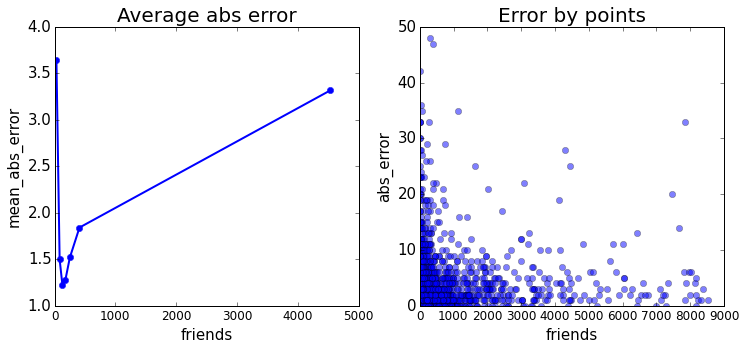

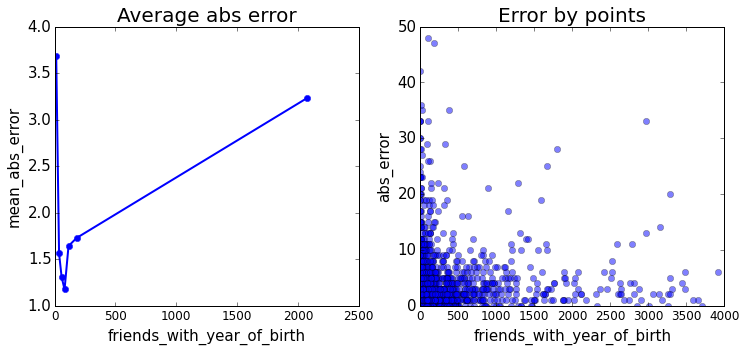

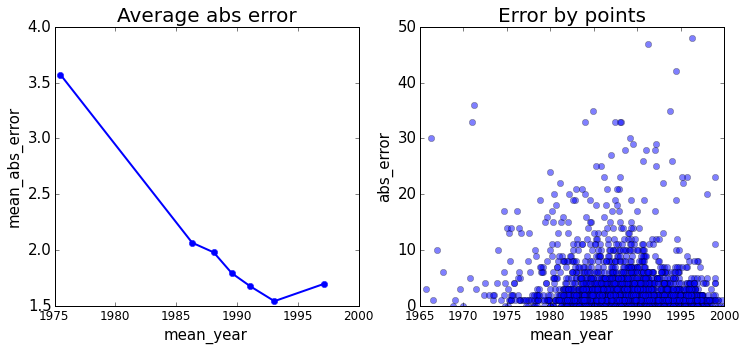

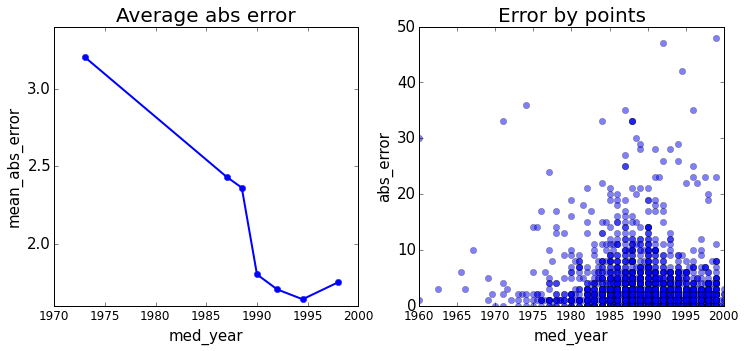

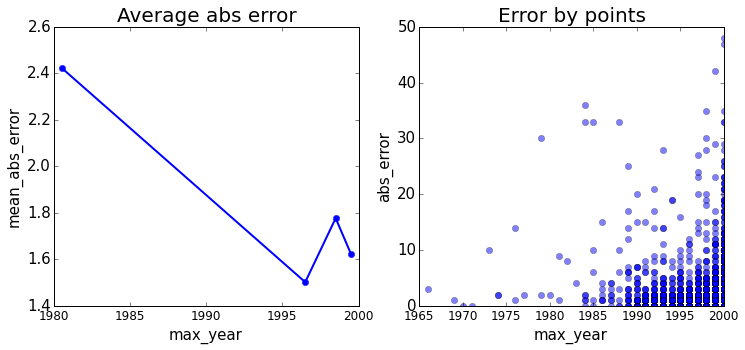

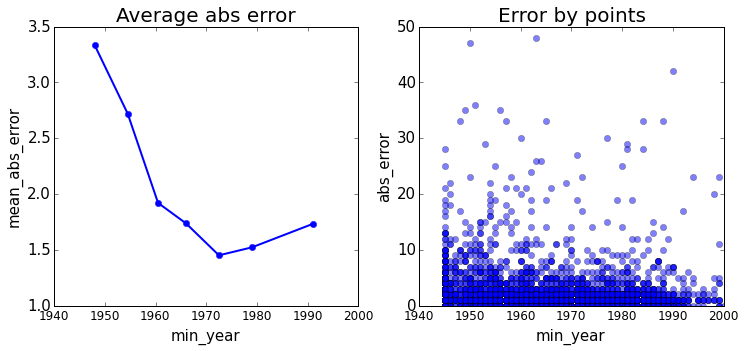

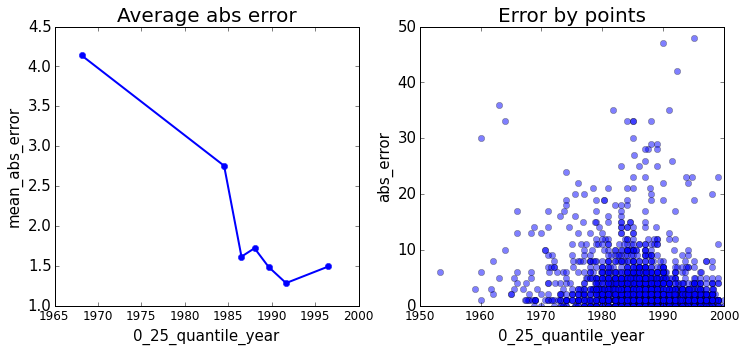

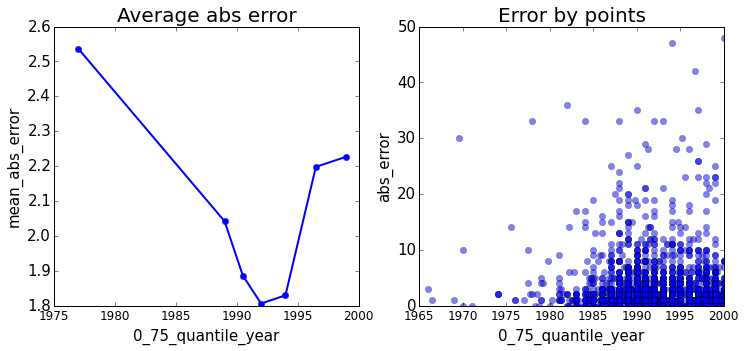

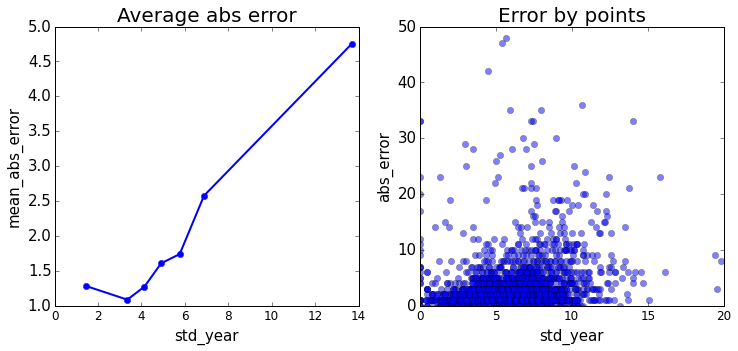

In [49]:
y_pred = estimator.predict(X_test)
for i in xrange(X_test.shape[1]):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    error, feature_values = ResearchErrorQuantiles(y_test, y_pred, X_test[:, i], bins=7)
    plt.plot(feature_values, error, 'b-', linewidth=2)
    plt.plot(feature_values, error, 'b.', ms=12)
    if i < 2:
        plt.xlabel(list(birth_data_frame.columns)[i], fontsize=15)
    else:
        plt.xlabel(list(birth_data_frame.columns)[i] + '_year', fontsize=15)
    plt.ylabel('mean_abs_error', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)
    plt.title('Average abs error', fontsize=20)
    
    plt.subplot(122)
    plt.plot(X_test[:, i], np.abs(y_test - np.round(y_pred)), 'bo', alpha=0.5)
    if i < 2:
        plt.xlabel(list(birth_data_frame.columns)[i], fontsize=15)
    else:
        plt.xlabel(list(birth_data_frame.columns)[i] + '_year', fontsize=15)
    plt.ylabel('abs_error', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)
    plt.title('Error by points', fontsize=20)

1) Максимальная точность предсказания года рождения человека достигается, если количество его друзей от 150 до 200. В этом случае средняя ошибка прогноза оказывается меньше 1.5 лет. Если у человека друзей меньше, то качество предсказания уменьшается из-за недостатка информации. Если друзей больше, то информации оказывается избыточное количество. Если у человека более 500 друзей, то велика вероятность, что среди них будет много людей, которые почти с ним не знакомы, а значит, их возраст ничего не говорит о возрасте пользователя.

2) Выводы по количеству друзей с указанным годом рождения такие же, как было сказано выше, только оптимальное для предсказания количество таких друзей от 100 до 150 (границы в обоих случаях примерные, определены на глаз по графику).

3) Наибольшая точность предсказания года рождения человека достигается, если средний и медианный год рождения его друзей, а также 0.25 и 0.75 квантили попадают в диапазон с 1990 по 1997 годы.

4) Более точны прогнозы, если максимальный год рождения друзей примерно 1997, а минимальный - примерно 1970.

5) Наибольшей точностью обладают прогнозы для пользователей, у которых стандартное отклонение годов рождения друзей от 2 до 4.

Еще построим график зависимости качества прогноза года рождения от самого года рождения, чтобы понять, для каких возрастных групп год рождения определяется наиболее точно.

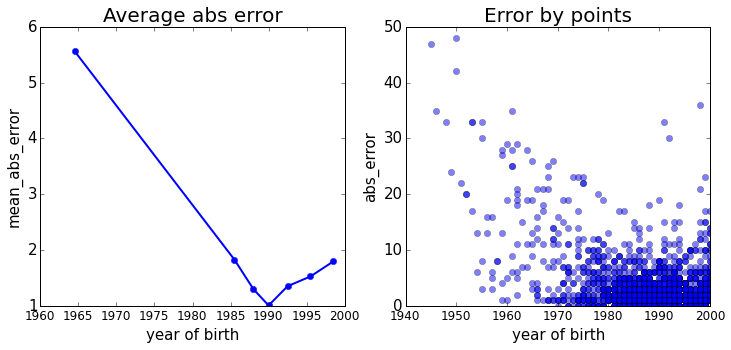

In [50]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
error, feature_values = ResearchErrorQuantiles(y_test, y_pred, y_test, bins=7)
plt.plot(feature_values, error, 'b-', linewidth=2)
plt.plot(feature_values, error, 'b.', ms=12)
plt.xlabel('year of birth', fontsize=15)
plt.ylabel('mean_abs_error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.title('Average abs error', fontsize=20)
    
plt.subplot(122)
plt.plot(y_test, np.abs(y_test - np.round(y_pred)), 'bo', alpha=0.5)
plt.xlabel('year of birth', fontsize=15)
plt.ylabel('abs_error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.title('Error by points', fontsize=20)

Максимальная точность предсказания года рождения для людей, родившихся с 1985 по 1995 годы.

## Выводы по предсказанию года рождения

Средняя ошибка предсказания года рождения пользователя по статистикам возрастов его друзей чуть больше двух лет. Точность предсказания зависит от возрастной категории пользователя (наиболее точны продсказания для людей, родившихся в окрестности 1990 года - средняя ошибка 1 год). Также точность зависит от количества друзей у пользователя, минимальная ошибка предсказания наблюдается для пользователей с 150-200 друзьями. Есть зависимость от стандартного отклонения годов рождения друзей - минимум ошибки в интервале от 2 до 4. Для различных значений остальных статистик возрастов друзей точность определения года тоже отличается. Минимальная ошибка достигается, если значения этих статистик лежат в диапазоне от 1990 до 1997 года рождения, кроме минимального года рождения, для которого наименьшая ошибка в районе 1970 г.р.